<span style="font-size:50px"><strong>ML4HC Project 1 - Task 3</strong></span>


In [95]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F



# Define paths
data_dir = "../ml4h_data/p1/"#"data"

pd.set_option('display.max_columns', None)


# Transformer Model - Q2.3

### Model and training loop

In [84]:
class Transformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, num_classes=1, max_len=700,dropout=0.1):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_head = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, F)
        x = self.input_proj(x)                     # -> (B, T, D)
        x = x + self.positional_encoding[:, :x.size(1)]  # add position info
        x = self.transformer(x)                    # -> (B, T, D)
        x = x.mean(dim=1)                          # average pooling
        return self.cls_head(x).squeeze(-1)


In [ ]:
def train_transformer(model, dataloader, val_dataloader=None, epochs=10, lr=1e-3, weight_decay=0.0, device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu", checkpoint_path="best_model.pt"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()

    history = {"train_loss": [], "val_loss": [], "val_auroc": [], "val_auprc": []}
    best_auroc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        history["train_loss"].append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}")

        if val_dataloader:
            auroc, auprc, val_loss = evaluate_transformer(model, val_dataloader, device)
            history["val_loss"].append(val_loss)
            history["val_auroc"].append(auroc)
            history["val_auprc"].append(auprc)
            print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")

            if auroc > best_auroc:
                best_auroc = auroc
                best_state = model.state_dict()

    if best_state:
        torch.save(best_state, checkpoint_path)
        print(f"✅ Best model saved with AUROC = {best_auroc:.4f} at {checkpoint_path}")

    plot_training_curves(history)
    return history

In [131]:

def plot_training_curves(history):
    epochs_range = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    if history["val_loss"]:
        plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["val_auroc"], label="AUROC")
    plt.xlabel("Epoch"); plt.ylabel("AUROC"); plt.title("Validation AUROC")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["val_auprc"], label="AUPRC")
    plt.xlabel("Epoch"); plt.ylabel("AUPRC"); plt.title("Validation AUPRC")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [7]:

def evaluate_transformer(model, dataloader, device):
    model.eval()
    all_probs, all_labels = [], []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu()
            all_probs.append(probs)
            all_labels.append(y_batch.cpu())

    probs = torch.cat(all_probs)
    labels = torch.cat(all_labels)

    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)
    val_loss = total_loss / len(dataloader)

    print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")
    return auroc, auprc, val_loss


In [8]:
def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled.parquet")

    df = df.sort_values(by=["RecordID", "Time"])

    # Move RecordID and Time to the front
    cols = ["RecordID", "Time"] + [col for col in df.columns if col not in ["RecordID", "Time"]]
    df = df[cols]

    # Remove label from features
    features = [col for col in df.columns if col not in ["RecordID", "Time", "In-hospital_death"]]

    # Group time series per patient
    grouped = df.groupby("RecordID")[features].apply(lambda x: x.to_numpy()).tolist()
    assert all(x.shape == (49, 40) for x in grouped), "Not all patients have shape (49, 41)"

    # Convert to tensor
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in grouped])  # (N, 49, 41)

    # Extract labels
    y = torch.tensor(df.groupby("RecordID")["In-hospital_death"].first().values, dtype=torch.float32)

    dataset = TensorDataset(X, y) 
    return dataset


### Testing

In [9]:
train_dataset = get_data("train")
val_dataset = get_data("val")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



Epoch 1/5 - Train Loss: 0.4094
Val AUROC: 0.5962  AUPRC: 0.1827  Val Loss: 0.4124
Val AUROC: 0.5962  AUPRC: 0.1827  Val Loss: 0.4124
Epoch 2/5 - Train Loss: 0.4046
Val AUROC: 0.7414  AUPRC: 0.3315  Val Loss: 0.4056
Val AUROC: 0.7414  AUPRC: 0.3315  Val Loss: 0.4056
Epoch 3/5 - Train Loss: 0.3672
Val AUROC: 0.7843  AUPRC: 0.4031  Val Loss: 0.3538
Val AUROC: 0.7843  AUPRC: 0.4031  Val Loss: 0.3538
Epoch 4/5 - Train Loss: 0.3446
Val AUROC: 0.7629  AUPRC: 0.4186  Val Loss: 0.3497
Val AUROC: 0.7629  AUPRC: 0.4186  Val Loss: 0.3497
Epoch 5/5 - Train Loss: 0.3503
Val AUROC: 0.7892  AUPRC: 0.3823  Val Loss: 0.3418
Val AUROC: 0.7892  AUPRC: 0.3823  Val Loss: 0.3418
✅ Best model saved with AUROC = 0.7892 at best_model.pt


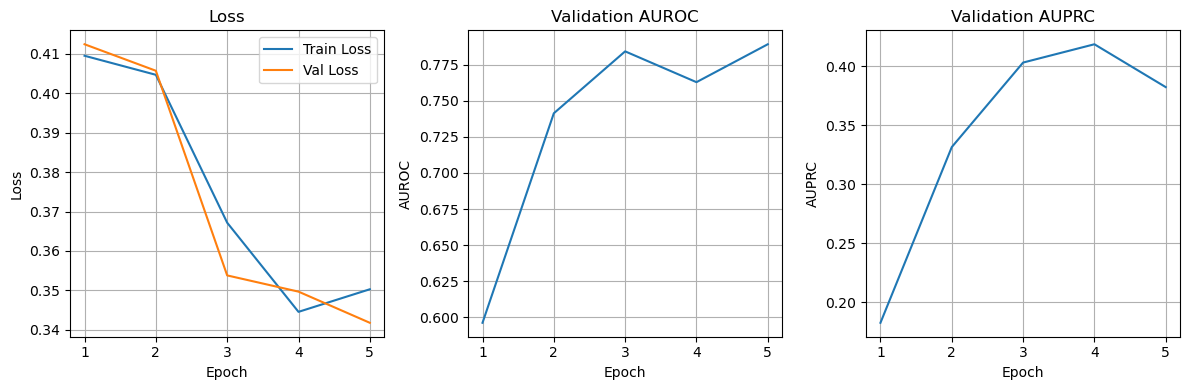

{'train_loss': [0.4094467160701752,
  0.40462010848522184,
  0.36716575968265536,
  0.34458487820625305,
  0.3503050824403763],
 'val_loss': [0.4123578779697418,
  0.40564864790439603,
  0.3538136981725693,
  0.3497051717042923,
  0.3418138462305069],
 'val_auroc': [np.float64(0.5962248945303523),
  np.float64(0.7413639031156637),
  np.float64(0.7842617329853245),
  np.float64(0.7629238792310976),
  np.float64(0.7891830513969598)],
 'val_auprc': [np.float64(0.18271350756548826),
  np.float64(0.33153975312727424),
  np.float64(0.403123651585671),
  np.float64(0.41862391250915715),
  np.float64(0.38232661613787056)]}

In [10]:
model = Transformer(input_dim=40, model_dim=64, num_layers=3, dropout=0.1)


train_transformer(model, train_loader, val_dataloader=val_loader, epochs=5, lr=1e-3)

## Q2.3b: Tokenizing Time-Series Data and Transformers 

In [82]:
def get_data_set_function(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled_nonImputed.parquet")

    df["Time"] = df["Time"] / df["Time"].max()
    df = df.melt(id_vars=["RecordID", "Time"], var_name="Variable", value_name="Value")
    df = df[["RecordID", "Time", "Variable", "Value"]].reset_index(drop=True)

    # Drop ICUType
    df = df[df["Variable"] != "ICUType"]

    # For Gender, Age, Height — keep only row with smallest time per RecordID
    mask = df["Variable"].isin(["Gender", "Age", "Height", "In-hospital_death"])
    df = df[~mask | df.groupby(["RecordID", "Variable"])["Time"].transform("min").eq(df["Time"])]
    df = df.sort_values(by=["RecordID", "Time"]).reset_index(drop=True)
    df = df.dropna(subset=["Value"]).reset_index(drop=True)

    # Create target dataframe y with one row per RecordID
    y = df[df["Variable"] == "In-hospital_death"][["RecordID", "Value"]].copy()
    y = y.rename(columns={"Value": "In-hospital_death"}).set_index("RecordID")

    # Remove In-hospital_death rows from df
    df = df[df["Variable"] != "In-hospital_death"].reset_index(drop=True)
    #df.head(10)

    df = pd.get_dummies(df, columns=["Variable"],dtype=int)
    #df.head(3)

    trans_df = df.T
    column_groups= trans_df.columns.to_series().groupby(trans_df.iloc[0]).apply(list)
    trans_df = trans_df.iloc[1:]  # drop first row

    #pd.DataFrame(trans_df).iloc[:10, :20]

    # group columns by RecordID using the earlier group mapping
    patient_tensors = [
        torch.tensor(trans_df[cols].to_numpy(dtype="float32").T)  # shape: (T, F) per patient
        for cols in column_groups.values
    ]

    X = pad_sequence(patient_tensors, batch_first=True)  # shape: (N, max_T, F)
    print(X.shape[1])

    # convert labels from the y df created earlier
    y_tensor = torch.tensor(y.loc[column_groups.index, "In-hospital_death"].values, dtype=torch.float32)

    assert X.shape[0] == y_tensor.shape[0], "Mismatch between input and label sizes"
    dataset = TensorDataset(X, y_tensor)
    return dataset


678
690
Epoch 1/5 - Train Loss: 0.4084
Val AUROC: 0.5503  AUPRC: 0.1638  Val Loss: 0.4116
Val AUROC: 0.5503  AUPRC: 0.1638  Val Loss: 0.4116
Epoch 2/5 - Train Loss: 0.4038
Val AUROC: 0.5068  AUPRC: 0.1461  Val Loss: 0.4113
Val AUROC: 0.5068  AUPRC: 0.1461  Val Loss: 0.4113
Epoch 3/5 - Train Loss: 0.4030
Val AUROC: 0.5245  AUPRC: 0.1573  Val Loss: 0.4095
Val AUROC: 0.5245  AUPRC: 0.1573  Val Loss: 0.4095
Epoch 4/5 - Train Loss: 0.4026
Val AUROC: 0.5840  AUPRC: 0.2094  Val Loss: 0.4206
Val AUROC: 0.5840  AUPRC: 0.2094  Val Loss: 0.4206
Epoch 5/5 - Train Loss: 0.4056
Val AUROC: 0.5805  AUPRC: 0.2043  Val Loss: 0.4091
Val AUROC: 0.5805  AUPRC: 0.2043  Val Loss: 0.4091
✅ Best model saved with AUROC = 0.5840 at best_model.pt


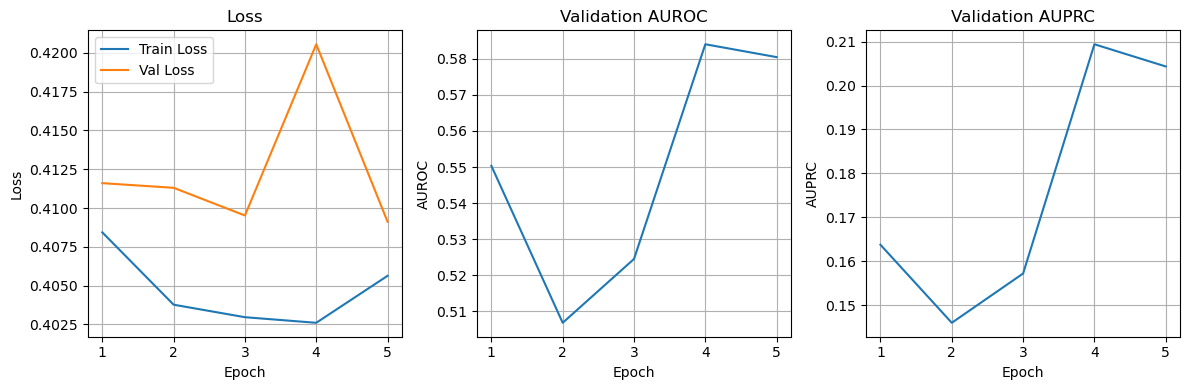

{'train_loss': [0.4084338986873627,
  0.4037736687660217,
  0.4029674825668335,
  0.4026074243783951,
  0.40563484573364256],
 'val_loss': [0.4116030453443527,
  0.41130348515510556,
  0.4095201174020767,
  0.4205510402917862,
  0.4091173303127289],
 'val_auroc': [np.float64(0.5503402114317607),
  np.float64(0.5068185922059161),
  np.float64(0.5245160502642897),
  np.float64(0.58404740799107),
  np.float64(0.5804806255950621)],
 'val_auprc': [np.float64(0.1637948021532585),
  np.float64(0.14605683472866043),
  np.float64(0.15726065818548696),
  np.float64(0.20937582279853031),
  np.float64(0.20433082718415296)]}

In [85]:
train_dataset_set_function = get_data_set_function("train")
val_dataset_set_function = get_data_set_function("val")

train_loader_set_function = DataLoader(train_dataset_set_function, batch_size=32, shuffle=True)
val_loader_set_function = DataLoader(val_dataset_set_function, batch_size=32)

model_set_function = Transformer(input_dim=41, model_dim=64, num_layers=3, dropout=0.1)

train_transformer(model_set_function, train_loader_set_function, val_dataloader=val_loader_set_function, epochs=5, lr=1e-3)

#  Pretraining and linear probes - Q3.1

## Model and training functions for pretraining task

In [ ]:
class CPCTransformer_old(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, max_len=690, dropout=0.1, pred_steps=5):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)
        #self.positional_encoding = nn.Parameter(torch.randn(1, max_len, model_dim))

        # Encoder to get latent representations z_t
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Autoregressive model g_ar (Transformer to summarize z_<=t into c_t)
        ar_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.g_ar = nn.TransformerEncoder(ar_layer, num_layers=1)

        self.pred_steps = pred_steps
        self.prediction_heads = nn.ModuleList([
            nn.Linear(model_dim, model_dim) for _ in range(pred_steps)
        ])

    def forward(self, x):
        # x: (B, T, F)
        x = self.input_proj(x)                                 # (B, T, D)
        #x = x + self.positional_encoding[:, :x.size(1)]        # Add positional encoding
        z = self.encoder(x)                                    # (B, T, D)
        c = self.g_ar(z)                                       # (B, T, D)
        c_t = c[:, -1, :]                                      # Use only final time step context
        return z, c_t  # Return full latents and final context vector


In [120]:
class CPCTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=3, max_len=690, dropout=0.1, pred_steps=5):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        # Create encoder layers + downsampling layers
        self.encoder_blocks = nn.ModuleList()
        
        for _ in range(num_layers):
            block = nn.Sequential(
                nn.TransformerEncoderLayer(
                    d_model=model_dim,
                    nhead=num_heads,
                    dropout=dropout,
                    batch_first=True
                ),
                nn.Conv1d(in_channels=model_dim, out_channels=model_dim, kernel_size=3, stride=2, padding=1)
            )
            self.encoder_blocks.append(block)

        self.g_ar = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=model_dim,
                nhead=num_heads,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=1
        )

        self.pred_steps = pred_steps
        self.prediction_heads = nn.ModuleList([
            nn.Linear(model_dim, model_dim) for _ in range(pred_steps)
        ])

    def forward(self, x):
        x = self.input_proj(x)  # (B, T, D)

        # Sequentially apply transformer + downsampling
        for block in self.encoder_blocks:
            x = block[0](x)             # transformer layer
            x = x.permute(0, 2, 1)      # (B, D, T) for Conv1d
            x = block[1](x)             # downsampling
            x = x.permute(0, 2, 1)      # (B, T, D) back

        z = x
        c = self.g_ar(z)               # autoregressive context
        c_t = c[:, -1, :]
        return z, c_t


In [114]:
def cpc_loss(z, c_t, prediction_heads, pred_steps=5):
    """
    z: (B, T, D) - latent sequence
    c_t: (B, D) - final context from g_ar
    prediction_heads: list of linear layers
    """
    B, T, D = z.shape
    device = z.device
    loss = 0.0
    n_loss_terms = 0

    for k in range(1, pred_steps + 1):
        if T <= k:
            continue  # skip if not enough future steps

        z_target = z[:, -1 + k, :]  # true future latent
        Wk = prediction_heads[k - 1]
        z_pred = Wk(c_t)
        pos_score = torch.sum(z_pred * z_target, dim=-1)

        # Negative sampling
        neg_indices = torch.randperm(B)
        z_neg = z[neg_indices, -1 + k, :]
        neg_score = torch.sum(z_pred * z_neg, dim=-1)

        logits = torch.stack([pos_score, neg_score], dim=1)
        labels = torch.zeros(B, dtype=torch.long, device=device)

        loss += F.cross_entropy(logits, labels)
        n_loss_terms += 1

    return loss / n_loss_terms if n_loss_terms > 0 else torch.tensor(0.0, device=device)


In [ ]:
from tqdm import tqdm

def train_cpc(model, dataloader, epochs=10, lr=1e-3, device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"loss": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        batch_loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for x_batch, _ in batch_loop:
            x_batch = x_batch.to(device)

            z, c_t = model(x_batch)
            loss = cpc_loss(z, c_t, model.prediction_heads, model.pred_steps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        history["loss"].append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - CPC Loss: {avg_loss:.4f}")

    # extract embeddings (context vector c_t) for all data
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for x_batch, _ in tqdm(dataloader, desc="Extracting embeddings"):
            x_batch = x_batch.to(device)
            _, c_t = model(x_batch)
            all_embeddings.append(c_t)

    embeddings = torch.cat(all_embeddings, dim=0)  # (N, D)
    return history, embeddings


## Model evaluation and classification task

In [ ]:
train_dataset_pretraining = get_data_set_function("train")
val_dataset_pretraining   = get_data_set_function("val")
test_dataset_pretraining  = get_data_set_function("test")

batch_size=64
train_loader_pretraining = DataLoader(train_dataset_pretraining, batch_size=batch_size, shuffle=True)
val_loader_pretraining   = DataLoader(val_dataset_pretraining, batch_size=batch_size)
test_loader_pretraining  = DataLoader(test_dataset_pretraining, batch_size=batch_size)

model_pretrained = CPCTransformer(input_dim=41, model_dim=16, num_layers=3, dropout=0.1, pred_steps=1)

history, embeddings= train_cpc(model_pretrained, train_loader_pretraining, epochs=5, lr=1e-3)
#train_cpc(model__pretrained, train_loader_pretraining, val_dataloader=val_loader_pretraining, epochs=5, lr=1e-3)

678
630


Epoch 1/5: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


Epoch 1/5 - CPC Loss: 0.6977


Epoch 2/5: 100%|██████████| 63/63 [02:24<00:00,  2.30s/it]


Epoch 2/5 - CPC Loss: 0.6944


Epoch 3/5: 100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


Epoch 3/5 - CPC Loss: 0.6942


Epoch 4/5: 100%|██████████| 63/63 [02:38<00:00,  2.51s/it]


Epoch 4/5 - CPC Loss: 0.6948


Epoch 5/5: 100%|██████████| 63/63 [02:41<00:00,  2.56s/it]


Epoch 5/5 - CPC Loss: 0.6945


Extracting embeddings: 100%|██████████| 63/63 [00:27<00:00,  2.33it/s]


In [126]:
def extract_embeddings(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    all_embeddings, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            _, c_t = model(x_batch)
            all_embeddings.append(c_t.cpu())
            all_labels.append(y_batch.cpu())

    X = torch.cat(all_embeddings).numpy()
    y = torch.cat(all_labels).numpy()
    return X, y


In [129]:
def train_and_select_logreg(X_train, y_train, X_val, y_val, X_test, y_test, C_values=[0.01, 0.1, 1, 10]):
    best_clf = None
    best_auroc = -1
    best_c = None

    for c in C_values:
        clf = LogisticRegression(max_iter=1000, C=c)
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict_proba(X_val)[:, 1]
        val_auroc = roc_auc_score(y_val, y_val_pred)

        if val_auroc > best_auroc:
            best_auroc = val_auroc
            best_clf = clf
            best_c = c

    # Evaluate best model on test set
    y_test_pred = best_clf.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, y_test_pred)
    test_auprc = average_precision_score(y_test, y_test_pred)

    print(f"Best C={best_c} -> Test AUROC: {test_auroc:.4f}  AUPRC: {test_auprc:.4f}")
    return best_clf


In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# Freeze weights
for param in model_pretrained.parameters():
    param.requires_grad = False

# Extract embeddings
X_train, y_train = extract_embeddings(model_pretrained, train_loader_pretraining)
X_val, y_val     = extract_embeddings(model_pretrained, val_loader_pretraining)
X_test, y_test   = extract_embeddings(model_pretrained, test_loader_pretraining)

best_clf = train_and_select_logreg(
    X_train, y_train, X_val, y_val, X_test, y_test,
    C_values=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
)


Best C=0.0001 -> Test AUROC: 0.5496  AUPRC: 0.1877


#  Simulate label scarcity - Q3.2

In [133]:
def sample_dataloader(dataset, sample_size, batch_size=32, shuffle=False):
    indices = torch.randperm(len(dataset))[:sample_size]
    subset = torch.utils.data.Subset(dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

678
690
630
Epoch 1/5 - Train Loss: 0.4104
Val AUROC: 0.5969  AUPRC: 0.2249  Val Loss: 0.4095
Val AUROC: 0.5969  AUPRC: 0.2249  Val Loss: 0.4095
Epoch 2/5 - Train Loss: 0.4030
Val AUROC: 0.6033  AUPRC: 0.2326  Val Loss: 0.4092
Val AUROC: 0.6033  AUPRC: 0.2326  Val Loss: 0.4092
Epoch 3/5 - Train Loss: 0.4035
Val AUROC: 0.5914  AUPRC: 0.2202  Val Loss: 0.4077
Val AUROC: 0.5914  AUPRC: 0.2202  Val Loss: 0.4077
Epoch 4/5 - Train Loss: 0.4031
Val AUROC: 0.6089  AUPRC: 0.2375  Val Loss: 0.4075
Val AUROC: 0.6089  AUPRC: 0.2375  Val Loss: 0.4075
Epoch 5/5 - Train Loss: 0.4034
Val AUROC: 0.6077  AUPRC: 0.2364  Val Loss: 0.4080
Val AUROC: 0.6077  AUPRC: 0.2364  Val Loss: 0.4080
✅ Best model saved with AUROC = 0.6089 at best_model.pt


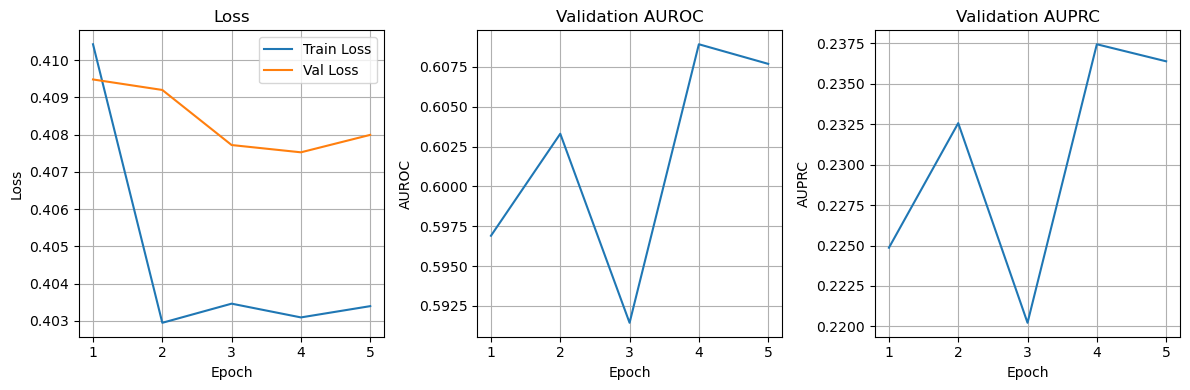

Val AUROC: 0.5844  AUPRC: 0.2256  Val Loss: 0.4165
Supervised AUROC: 0.5844, AUPRC: 0.2256


Epoch 1/5:  65%|██████▌   | 41/63 [05:43<04:50, 13.21s/it]

In [ ]:
import matplotlib.pyplot as plt

supervised_aurocs = []
supervised_auprcs = []
probe_aurocs = []
probe_auprcs = []
sample_sizes = [4000, 1000, 500, 100]

def run_comparison():
    for sample_size in sample_sizes:
        batch_size = 64

        # 1. Downsampled loaders (shared for supervised + CPC)
        train_loader_downsampled = sample_dataloader(get_data_set_function("train"), sample_size=sample_size, batch_size=batch_size, shuffle=True)
        val_loader               = DataLoader(get_data_set_function("val"),  batch_size=batch_size)
        test_loader              = DataLoader(get_data_set_function("test"), batch_size=batch_size)

        # 2. Supervised model
        model_supervised = Transformer(input_dim=41, model_dim=64, num_layers=3, dropout=0.1)
        train_transformer(model_supervised, train_loader_downsampled, val_dataloader=val_loader, epochs=5, lr=1e-3)

        # Save supervised model predictions on test set using evaluate_transformer
        test_auroc, test_auprc, _ = evaluate_transformer(model_supervised, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")
        supervised_aurocs.append(test_auroc)
        supervised_auprcs.append(test_auprc)
        print(f"Supervised AUROC: {test_auroc:.4f}, AUPRC: {test_auprc:.4f}")

        # 3. CPC model (unsupervised pretraining)
        model_unsupervised = CPCTransformer(input_dim=41, model_dim=64, num_layers=3, dropout=0.1, pred_steps=1)
        _, embeddings_train = train_cpc(model_unsupervised, train_loader_downsampled, epochs=5, lr=1e-3)
        _, embeddings_test  = extract_embeddings(model_unsupervised, test_loader)

        # 4. Get labels for linear probe
        y_train = torch.cat([y for _, y in train_loader_downsampled], dim=0).cpu().numpy()
        y_test  = torch.cat([y for _, y in test_loader], dim=0).cpu().numpy()

        # 5. Train + evaluate linear probe
        clf = LogisticRegression(max_iter=1000).fit(embeddings_train, y_train)
        y_pred = clf.predict_proba(embeddings_test)[:, 1]
        probe_auroc = roc_auc_score(y_test, y_pred)
        probe_auprc = average_precision_score(y_test, y_pred)
        probe_aurocs.append(probe_auroc)
        probe_auprcs.append(probe_auprc)
        print("Linear Probe AUROC:", probe_auroc)

def plot_comparison():
    # Plot AUROC and AUPRC comparison
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, supervised_aurocs, label="Supervised", marker='o')
    plt.plot(sample_sizes, probe_aurocs, label="Linear Probe", marker='x')
    plt.title("AUROC vs Sample Size")
    plt.xlabel("Training Samples")
    plt.ylabel("AUROC")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(sample_sizes, supervised_auprcs, label="Supervised", marker='o')
    plt.plot(sample_sizes, probe_auprcs, label="Linear Probe", marker='x')
    plt.title("AUPRC vs Sample Size")
    plt.xlabel("Training Samples")
    plt.ylabel("AUPRC")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run experiments and plot
run_comparison()
plot_comparison()

#  Visualising learned representations - Q3.3


In [ ]:
train_loader = DataLoader(get_data_set_function("train"), batch_size=64)
test_loader  = DataLoader(get_data_set_function("test"), batch_size=64)

model_unsupervised = CPCTransformer(input_dim=41, model_dim=4, num_layers=2, dropout=0.1, pred_steps=1)
history, embeddings = train_cpc(model_unsupervised, train_loader, epochs=1, lr=1e-3)

embeddings_test, y_test  = extract_embeddings(model_unsupervised, test_loader)



## Using TSNE

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

_, embeddings_test  = extract_embeddings(model_unsupervised, test_loader)


# Dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_test)

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=y_test, palette="Set1", s=40)
plt.title("t-SNE of Patient Embeddings")
plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.legend(title="In-hospital Death")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings_test)
nmi = normalized_mutual_info_score(y_test, kmeans.labels_)
ari = adjusted_rand_score(y_test, kmeans.labels_)

print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")


## Using UMAP

In [ ]:
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce embeddings to 2D with UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_model.fit_transform(embeddings_test)

# Plot UMAP projection colored by labels
plt.figure(figsize=(6, 5))
sns.scatterplot(x=embeddings_umap[:, 0], y=embeddings_umap[:, 1], hue=y_test, palette="deep", s=30)
plt.title("UMAP of Embeddings (colored by label)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Clustering evaluation
kmeans_umap = KMeans(n_clusters=2, random_state=42).fit(embeddings_umap)
nmi_umap = normalized_mutual_info_score(y_test, kmeans_umap.labels_)
ari_umap = adjusted_rand_score(y_test, kmeans_umap.labels_)

print(f"UMAP Clustering NMI: {nmi_umap:.4f}")
print(f"UMAP Clustering ARI: {ari_umap:.4f}")
